# **Empirical Notebook 04: Opacity, Discrimination and SHAP**

## **Section 1- Setup, imports, directories, and safe package installation**

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")


os.makedirs("figures", exist_ok=True)
os.makedirs("outputs", exist_ok=True)


def ensure_pkg(pkg):
    try:
        __import__(pkg)
    except Exception:
        print(f"Installing {pkg}...")
        import subprocess
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg, "--quiet"])


for pkg in ["shap", "scikit-learn", "fairlearn"]:
    ensure_pkg(pkg)


import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, average_precision_score, confusion_matrix, precision_recall_curve
)


print("Setup completed.")


Installing scikit-learn...
Setup completed.


## **Environment Information**

We dispay the current session information to ensure reproducibiity of the anaysis.

In [2]:
import session_info
session_info.show()

## **Section 2 - Dataset loading, sanity checks, and label reconstruction**

In [3]:
df = pd.read_csv("DatasetFinanceiro_v3.2.csv")
print("Shape:", df.shape)
display(df.head())


threshold = df['prob_inadimplencia'].quantile(0.90)
df['label_default'] = (df['prob_inadimplencia'] > threshold).astype(int)
print("label_default distribution:")
print(df['label_default'].value_counts())
print(df['label_default'].value_counts(normalize=True))
assert df['label_default'].nunique() == 2, "label_default must have 2 classes."


for c in ["sexo", "raca"]:
    if c not in df.columns:
        print(f"Note: sensitive column '{c}' not found (ok if intentional).")


Shape: (10000, 38)


,idade,estado_civil,escolaridade,renda_estim,regiao,tipo_emprego,tempo_emprego,num_cartoes,limite_total,utilizacao_media,...,A_sq,A_times_O,A2_logS,conf_modelo,label_default,entropia_pred,variabilidade_pred,drift_score,sexo,raca
0,45.960570,solteiro,fundamental,3292.988587,sudeste,clt,1.490885,3,12399.152432,0.289483,...,0.000069,0.004189,0.000005,0.431438,0,0.096900,0.069658,0.076812,feminino,branca
1,38.340828,solteiro,medio,1318.066261,nordeste,clt,8.287529,3,5586.978596,0.380147,...,0.083224,0.111108,0.026206,0.493034,0,0.128550,0.026706,0.058620,feminino,parda
2,47.772262,solteiro,pos,2580.672825,sudeste,desempregado,11.313190,3,7381.248391,0.343940,...,0.022817,0.065149,0.005168,0.464883,0,0.216693,0.068442,0.125284,feminino,parda
3,58.276358,solteiro,superior,1533.976251,nordeste,clt,16.081947,1,3660.305124,0.144685,...,0.076313,0.145576,0.035576,0.500190,0,0.069461,0.065740,0.044536,masculino,parda
4,37.190160,casado,medio,1218.687502,centro-oeste,clt,10.198240,2,5004.534675,0.391849,...,0.039450,0.085077,0.014982,0.462938,0,0.130632,0.059859,0.014876,masculino,parda


label_default distribution:
label_default
0    9000
1    1000
Name: count, dtype: int64
label_default
0    0.9
1    0.1
Name: proportion, dtype: float64


## **Section 3 - Feature preparation, sensitive encoding (audit-only), and stratified split**

In [4]:
features_model = [
    "utilizacao_media", "divida_renda", "historico_atrasos", "score_credito",
    "valor_medio_trans", "quant_transacoes", "transacoes_incomuns", "assinaturas",
    "compra_internacional",
    "A", "O", "H",  # theoretical components
    "entropia_pred", "variabilidade_pred", "drift_score"  # uncertainty
]
miss = [f for f in features_model if f not in df.columns]
if miss:
    raise KeyError(f"Missing features in dataset: {miss}")


# Sensitive variables - audit only
df_sens = pd.DataFrame()
if "sexo" in df.columns:
    df_sens = pd.get_dummies(df["sexo"], prefix="sexo", drop_first=True)
if "raca" in df.columns:
    df_sens = pd.get_dummies(df["raca"], prefix="raca", drop_first=True)


X = df[features_model].copy()
y = df["label_default"].copy()


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)
print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (7500, 15) Test: (2500, 15)


## **Section 4 - Base model training (Logistic + RandomForest) and calibration**

In [5]:
log_mod = LogisticRegression(max_iter=3000)
rf_mod = RandomForestClassifier(n_estimators=400, random_state=42)


log_mod.fit(X_train, y_train)
rf_mod.fit(X_train, y_train)


y_proba_log = log_mod.predict_proba(X_test)[:, 1]
y_proba_rf = rf_mod.predict_proba(X_test)[:, 1]


auc_log = roc_auc_score(y_test, y_proba_log)
auc_rf = roc_auc_score(y_test, y_proba_rf)
ap_log = average_precision_score(y_test, y_proba_log)
ap_rf = average_precision_score(y_test, y_proba_rf)


print(f"AUC ROC - Logistic: {auc_log:.3f} | RF: {auc_rf:.3f}")
print(f"PR-AUC - Logistic: {ap_log:.3f} | RF: {ap_rf:.3f}")


AUC ROC - Logistic: 0.960 | RF: 0.947
PR-AUC - Logistic: 0.778 | RF: 0.725


## **Section 5 - SHAP global and local explainability (RF and Logistic)**

100%|===================| 4993/5000 [06:42<00:00]        

<Figure size 640x480 with 0 Axes>

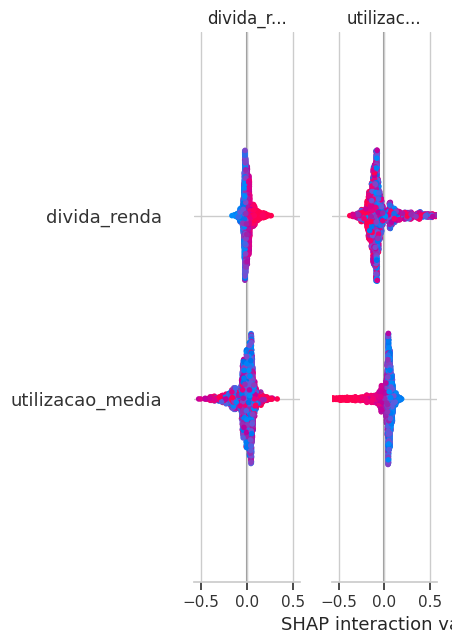

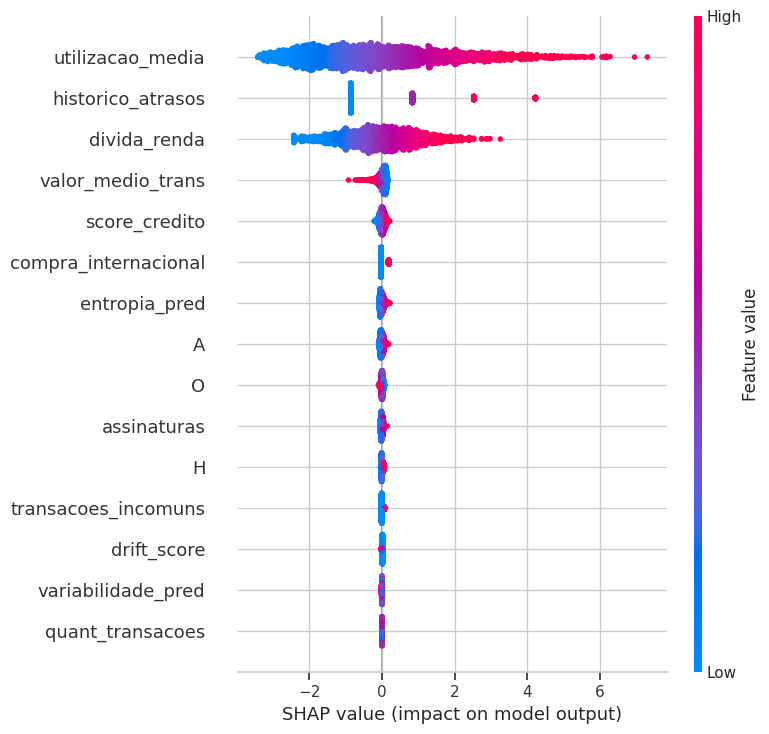

In [16]:
import shap
from shap import maskers


# RF - TreeExplainer with background masker to avoid warning
rf_background = maskers.Independent(X_train, max_samples=200)
explainer_rf = shap.TreeExplainer(rf_mod, data=rf_background)
shap_vals_rf = explainer_rf.shap_values(X_test)
shap_vals_rf_pos = shap_vals_rf[1] if isinstance(shap_vals_rf, list) else shap_vals_rf


# Summary plot - RF
plt.figure()
shap.summary_plot(shap_vals_rf_pos, X_test, show=False)
plt.tight_layout()
plt.savefig("figures/shap_summary_rf.png", dpi=300)
plt.show()


# Logistic - LinearExplainer with masker
log_background = maskers.Independent(X_train, max_samples=500)
explainer_log = shap.LinearExplainer(log_mod, log_background)
shap_vals_log = explainer_log.shap_values(X_test)
shap_vals_log_pos = shap_vals_log[1] if isinstance(shap_vals_log, list) else shap_vals_log


plt.figure()
shap.summary_plot(shap_vals_log_pos, X_test, show=False)
plt.tight_layout()
plt.savefig("figures/shap_summary_log.png", dpi=300)
plt.show()


## **Section 6- Fairness metrics (practical implementations)**

In [17]:
from collections import defaultdict


def binary_decisions(probas, thresh=0.5):
    return (probas >= thresh).astype(int)


def statistical_parity_difference(y_true, y_pred, sens):
    grp = pd.DataFrame({"y": y_true, "pred": y_pred, "sens": sens})
    p1 = grp[grp["sens"] == 1]["pred"].mean()
    p0 = grp[grp["sens"] == 0]["pred"].mean()
    return p1 - p0


def disparate_impact(y_true, y_pred, sens):
    grp = pd.DataFrame({"y": y_true, "pred": y_pred, "sens": sens})
    p1 = grp[grp["sens"] == 1]["pred"].mean()
    p0 = grp[grp["sens"] == 0]["pred"].mean()
    return p1 / (p0 + 1e-9)


def equality_of_opportunity(y_true, y_pred, sens):
    grp = pd.DataFrame({"y": y_true, "pred": y_pred, "sens": sens})
    tpr1 = grp[(grp["sens"] == 1) & (grp["y"] == 1)]["pred"].mean()
    tpr0 = grp[(grp["sens"] == 0) & (grp["y"] == 1)]["pred"].mean()
    return tpr1 - tpr0


pred_rf = binary_decisions(y_proba_rf, 0.5)
pred_log = binary_decisions(y_proba_log, 0.5)


fairness_results = []
for sens_name in ["sexo", "raca"]:
    if sens_name in df.columns:
        sens_series = df.loc[X_test.index, sens_name]
        if sens_series.dtype == object or sens_series.dtype.name == 'category':
            dummies = pd.get_dummies(sens_series, drop_first=False)
            sens_bin = dummies.iloc[:, 0]  # defina explicitamente qual é o grupo protegido no artigo
        else:
            sens_bin = (sens_series == 1).astype(int)


        fairness_results.append({
            "sensitive": sens_name,
            "spd_rf": statistical_parity_difference(y_test.values, pred_rf, sens_bin.values),
            "di_rf": disparate_impact(y_test.values, pred_rf, sens_bin.values),
            "eop_rf": equality_of_opportunity(y_test.values, pred_rf, sens_bin.values),
            "spd_log": statistical_parity_difference(y_test.values, pred_log, sens_bin.values),
            "di_log": disparate_impact(y_test.values, pred_log, sens_bin.values),
            "eop_log": equality_of_opportunity(y_test.values, pred_log, sens_bin.values),
        })


fair_df = pd.DataFrame(fairness_results)
display(fair_df)


,sensitive,spd_rf,di_rf,eop_rf,spd_log,di_log,eop_log
0,sexo,0.012727,1.223471,0.160897,0.002246,1.031180,0.082692
1,raca,0.007917,1.124659,-0.245935,-0.001791,0.975533,-0.323171


## **Section 7 - Algorithmic opacity proxy using SHAP and RF structure**

In [18]:
avg_tree_depth = np.mean([est.tree_.max_depth for est in rf_mod.estimators_])
avg_node_count = np.mean([est.tree_.node_count for est in rf_mod.estimators_])


shap_abs_mean = np.mean(np.abs(shap_vals_rf_pos), axis=0)
shap_norm = shap_abs_mean / (shap_abs_mean.sum() + 1e-9)
gini = 1 - np.sum(shap_norm ** 2)


opacity_proxy = {
    "avg_tree_depth": float(avg_tree_depth),
    "avg_node_count": float(avg_node_count),
    "shap_gini": float(gini)
}
print("Opacity proxy:", opacity_proxy)


Opacity proxy: {'avg_tree_depth': 21.735, 'avg_node_count': 846.52, 'shap_gini': 0.8736076804674351}


## **Section 8 - A × O × SHAP: risk surfaces, 2D/3D maps, regime analysis**

SHAP RF shape: (2500, 15)


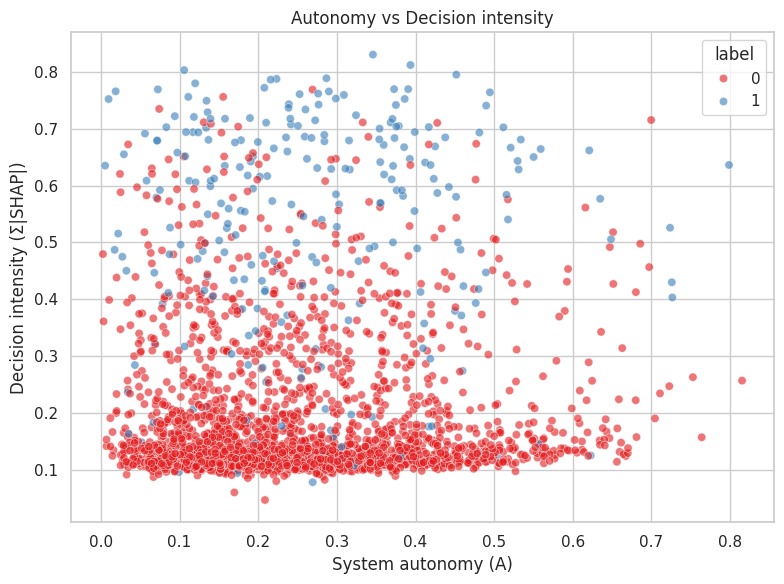

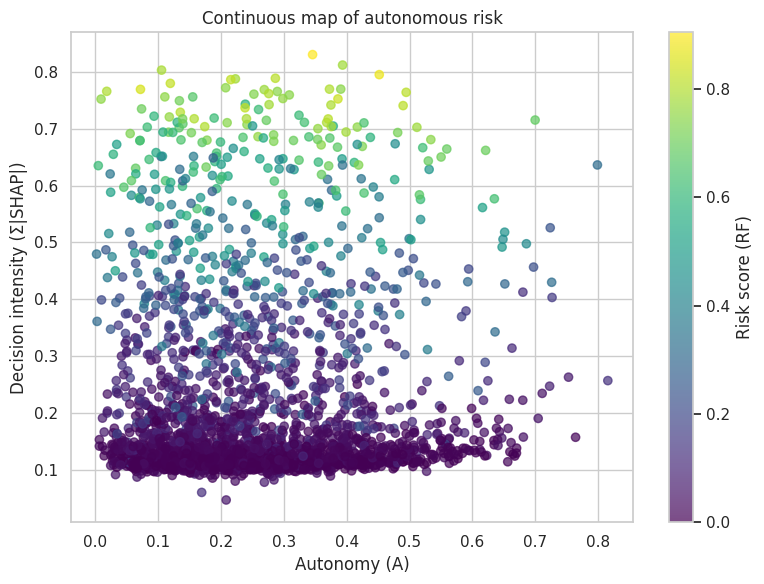

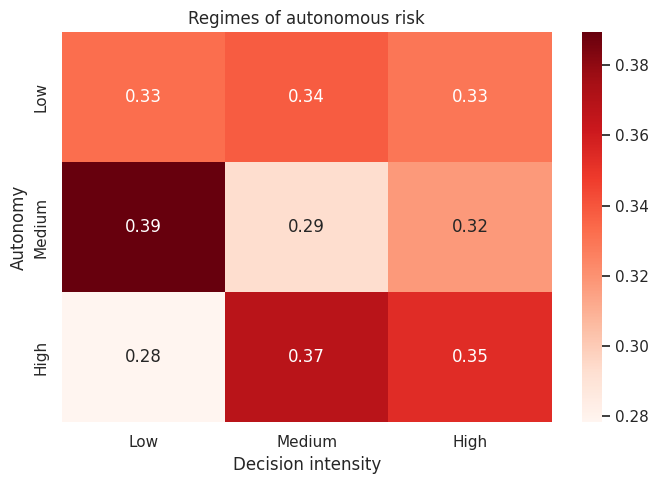

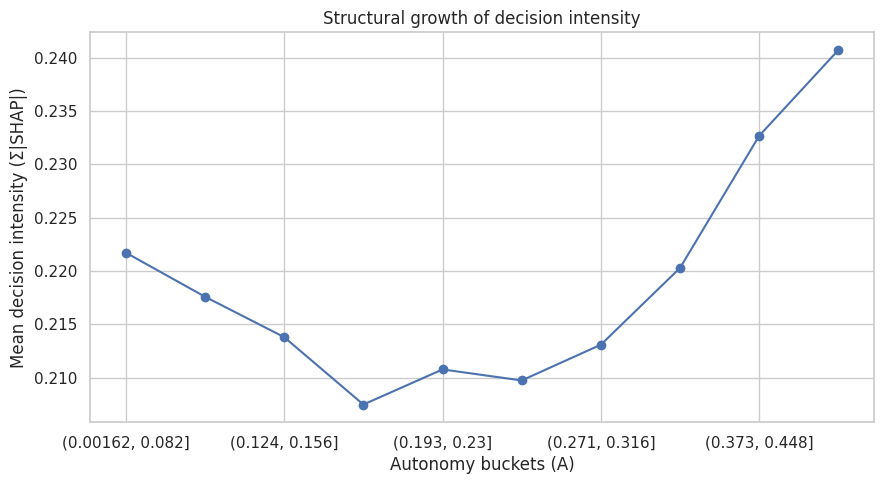

In [19]:
explainer_rf = shap.TreeExplainer(rf_mod)

# shap_values retorna lista: [class0, class1]
shap_values = explainer_rf.shap_values(X_test)

# Se lista, pegamos a classe positiva
if isinstance(shap_values, list) and len(shap_values) == 2:
    shap_vals_rf_pos = shap_values[1]   # classe positiva
else:
    shap_vals_rf_pos = shap_values[:, :, 1]      # Selecionar SHAP da classe positiva (classe 1)

print("SHAP RF shape:", shap_vals_rf_pos.shape)

# SHAP shape checks
assert shap_vals_rf_pos.ndim == 2, "shap_vals_rf_pos must be 2D"
assert shap_vals_rf_pos.shape[0] == len(X_test), "Same number of samples"
assert shap_vals_rf_pos.shape[1] == X_test.shape[1], "One contribution per feature"


shap_abs_sum = np.sum(np.abs(shap_vals_rf_pos), axis=1)
summary_df = pd.DataFrame({
    "A": df.loc[X_test.index, "A"].values,
    "shap_abs_sum": shap_abs_sum,
    "rf_score": y_proba_rf,
    "label": y_test.values
}, index=X_test.index)


# Scatter - A vs Σ|SHAP|
plt.figure(figsize=(8,6))
sns.scatterplot(x=summary_df["A"], y=summary_df["shap_abs_sum"],
                hue=summary_df["label"], alpha=0.6, palette="Set1")
plt.xlabel("System autonomy (A)")
plt.ylabel("Decision intensity (Σ|SHAP|)")
plt.title("Autonomy vs Decision intensity")
plt.grid(True)
plt.tight_layout()
plt.savefig("figures/autonomy_vs_intensity.png", dpi=300)
plt.show()


# Continuous risk map with colorbar
plt.figure(figsize=(8,6))
sc = plt.scatter(summary_df["A"], summary_df["shap_abs_sum"],
                 c=summary_df["rf_score"], cmap="viridis", alpha=0.7)
cbar = plt.colorbar(sc)
cbar.set_label("Risk score (RF)")
plt.xlabel("Autonomy (A)")
plt.ylabel("Decision intensity (Σ|SHAP|)")
plt.title("Continuous map of autonomous risk")
plt.grid(True)
plt.tight_layout()
plt.savefig("figures/continuous_autonomous_risk_map.png", dpi=300)
plt.show()


# Regimes - heatmap
summary_df["A_regime"] = pd.qcut(summary_df["A"], 3, labels=["Low", "Medium", "High"])
summary_df["SHAP_regime"] = pd.qcut(summary_df["shap_abs_sum"], 3, labels=["Low", "Medium", "High"])
regime_table = pd.crosstab(summary_df["A_regime"], summary_df["SHAP_regime"], normalize="index")


plt.figure(figsize=(7,5))
sns.heatmap(regime_table, annot=True, fmt=".2f", cmap="Reds")
plt.title("Regimes of autonomous risk")
plt.xlabel("Decision intensity")
plt.ylabel("Autonomy")
plt.tight_layout()
plt.savefig("figures/autonomous_risk_regimes.png", dpi=300)
plt.show()


# Mean intensity by A buckets
bucket_df = summary_df.copy()
bucket_df["A_bucket"] = pd.qcut(bucket_df["A"], q=10)
mean_shap_by_A = bucket_df.groupby("A_bucket", observed=False)["shap_abs_sum"].mean()


plt.figure(figsize=(9,5))
mean_shap_by_A.plot(marker="o")
plt.ylabel("Mean decision intensity (Σ|SHAP|)")
plt.xlabel("Autonomy buckets (A)")
plt.title("Structural growth of decision intensity")
plt.grid(True)
plt.tight_layout()
plt.savefig("figures/mean_intensity_by_autonomy_bucket.png", dpi=300)
plt.show()


## **Section 9 - Automatic audit for prohibited variables**

In [20]:
prohibited = ["sexo", "raca"]
report = {
    "found_in_train": [c for c in prohibited if c in X_train.columns],
    "found_in_test": [c for c in prohibited if c in X_test.columns],
}
if report["found_in_train"] or report["found_in_test"]:
    print("ALERT: Sensitive variables found in model features!")
    print(report)
else:
    print("Audit: OK - sensitive variables do NOT enter the models.")


Audit: OK - sensitive variables do NOT enter the models.


## **Section 10 - Conclusion (Opacity and Limits of Control)**

This notebook demonstrates that local interpretability mechanisms, such as SHAP, can coexist with increasing structural opacity at the system level. While feature attribution enables post hoc explanation of individual decisions, it does not prevent the emergence of diffuse internal representations, persistent decision pathways, or feedback-driven amplification of risk.

The results show that variables associated with sensitive attributes may acquire structural relevance without explicit optimization toward discriminatory outcomes. In such settings, opacity functions not as a lack of explanation, but as an asymmetry of control, limiting the capacity of human supervisors to anticipate, constrain, or correct emergent dynamics.

These findings support the central claim of the article: 

> explainability alone is insufficient as a governance mechanism in autonomous systems operating under feedback and partial supervision. Effective oversight must therefore account for system-level dynamics and temporal accumulation of risk, rather than relying solely on local interpretability signals.